In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import librosa
import os
import tensorflow.keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np
from tqdm import tqdm
from glob import glob
from matplotlib import pyplot as plt
import IPython.display as ipd
%matplotlib inline
from tensorflow.keras.utils import plot_model
from keras.datasets import fashion_mnist
import tensorflow as tf


# audio preprocessing:
1. Audio padding and clipping

    i. if smaller than mentioned length **then padding**
    
    ii. if larger than mentioned length **then clip**
2. Melspectrogram
3. Normalization(may be to be done)

In [ ]:
def wav2mls(file_path, n_mels=128, max_len=32): #,sampling_rate=16000,mls_shape_1=32):
  wave, sr = librosa.load(file_path, mono=True,sr=None)
                                                                                 # wave = np.asfortranarray(wave[::3])
  mls = librosa.feature.melspectrogram(wave, sr=16000)#,n_mels=n_mels)
                                                                                 # print(mls.shape)
  # If maximum length exceeds mfcc lengths then pad the remaining ones
  if (max_len > mls.shape[1]):
                                                                                 # print("d")
      pad_width = max_len - mls.shape[1]
      mls = np.pad(mls, pad_width=((0, 0), (0, pad_width)), mode='constant')

  # Else cutoff the remaining parts
  else:
                                                                                  # print("abc")
      mls = mls[:, :max_len]
  
                                                                                 # print("out mls:",mls.shape)
  return mls


In [ ]:
audio_data2_super_folder = glob("/content/drive/MyDrive/ML1_Course_Project/audio_data2/*")
all_mel_spectrograms = []
for class_folder in audio_data2_super_folder:
  class_wav_files = glob(class_folder+"/*")
  for wav_file in class_wav_files:
    melspec = wav2mls(file_path = wav_file,n_mels=128,max_len=32)
    print("\n")
    all_mel_spectrograms.append(melspec)
    mel_file_saving_path = "/content/drive/MyDrive/ML1_Course_Project/audio_data2_mel_spectrogram/"+wav_file[len("/content/drive/MyDrive/ML1_Course_Project/audio_data2/"):-4] +".npy" 

    np.save(mel_file_saving_path,melspec)
    
  
np.save("/content/drive/MyDrive/ML1_Course_Project/all_mel_spectrograms.npy",all_mel_spectrograms)


Streaming output truncated to the last 5000 lines.























































































































































































































































































































































































































































































































































































































































































































































































































































































































































































In [ ]:
def print_plot_play(x, Fs=16000, text="WAV FILE PLOT"):

    print('%s Fs = %d, x.shape = %s, x.dtype = %s' % (text, Fs, x.shape, x.dtype))
    plt.figure(figsize=(8, 2))
    plt.plot(x, color='gray')
    plt.xlim([0, x.shape[0]])
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()
    ipd.display(ipd.Audio(data=x, rate=Fs))


In [ ]:
from skimage.transform import resize
import random

def get_img_batch(audios_list,images_list,batch_size=5188,size=(128,128),should_normalise=False):
    batch_cover = []
    batch_secret = []
    overall_input = []

    for i in range(batch_size):
        img_secret= audios_list[i] ## audios_list : audio melspectrogrmas dataset 
        img_cover = random.choice(images_list)  ## images_list : image dataset

        img_secret = resize(img_secret,(128,32,1))
        img_cover = resize(img_cover, (128,32,3))

        # img_cover = np.array(img_cover,dtype=np.float32)
        
        # img_secret /= 255.
        # img_cover /= 255.

        # overall_input.append([img_secret,img_cover])
        batch_cover.append(img_cover)
        batch_secret.append(img_secret)
        
    batch_cover,batch_secret = np.array(batch_cover), np.array(batch_secret)

    if should_normalise:
        batch_cover = normalize_batch(batch_cover)
        batch_secret = normalize_batch(batch_secret)

    return batch_secret,batch_cover

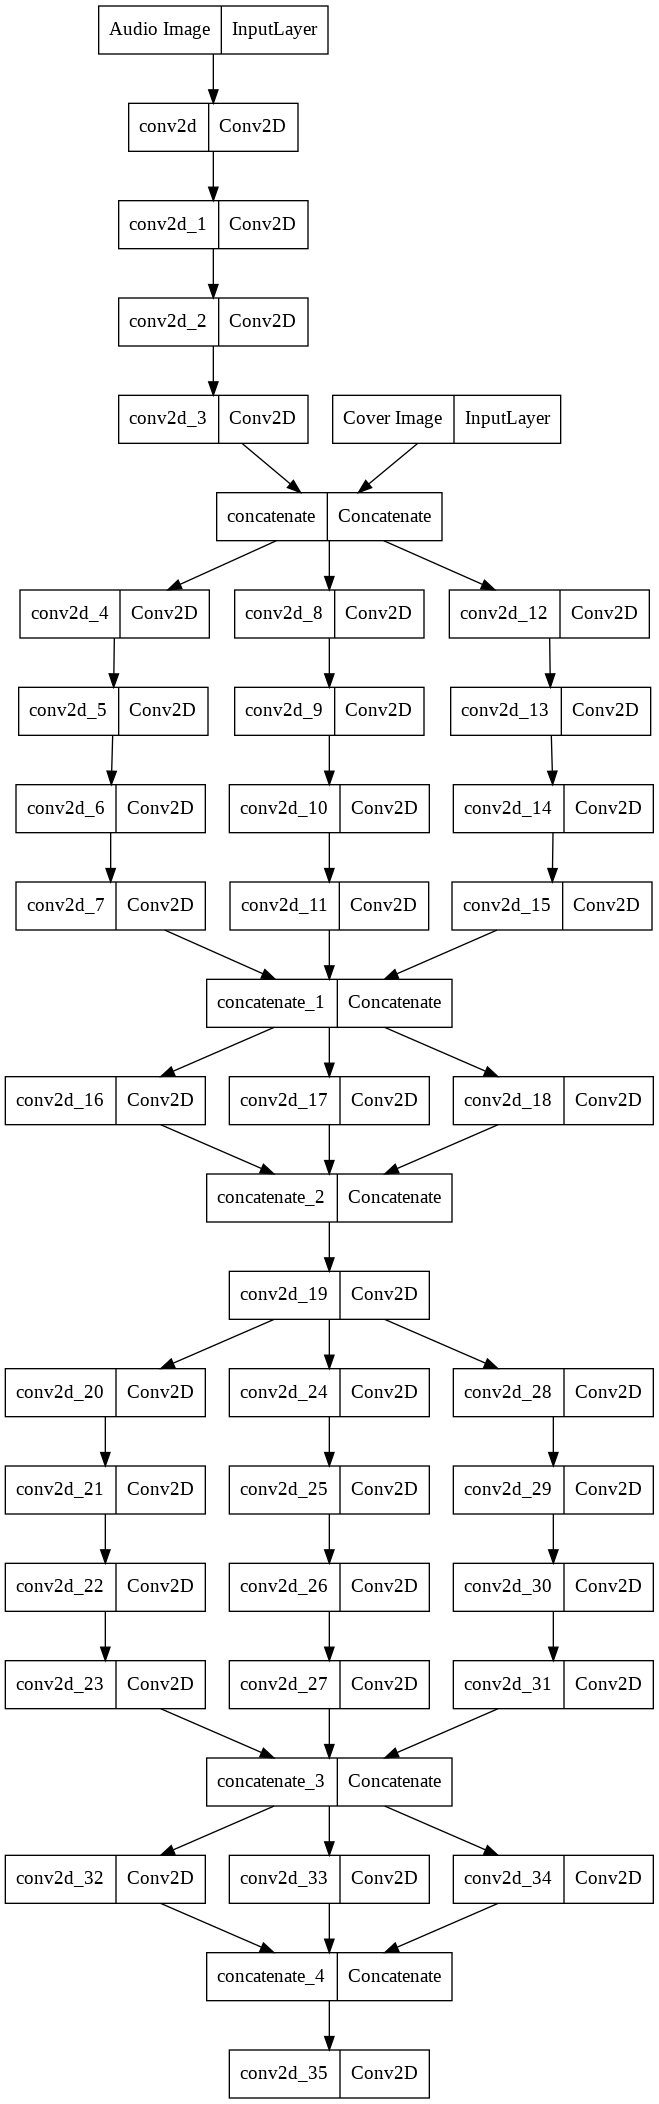

In [ ]:
# Changes

from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate, Activation, Dropout, Flatten, Dense

# def combined_model():
input_shape1 = Input(shape=(128, 32, 1), name = "Audio Image")
input_shape2 = Input(shape=(128, 32, 3), name = "Cover Image")

# Audio Feature Extraction
par1 = Conv2D(50, 3, padding='same', activation='tanh')(input_shape1)
par1 = Conv2D(50, 3, padding='same', activation='tanh')(par1)
par1 = Conv2D(50, 3, padding='same', activation='tanh')(par1)
par1 = Conv2D(50, 3, padding='same', activation='tanh')(par1)

# par2 = Conv2D(50, 4, padding='same', activation='relu')(input_shape1)
# par2 = Conv2D(50, 4, padding='same', activation='relu')(par2)
# par2 = Conv2D(50, 4, padding='same', activation='relu')(par2)
# par2 = Conv2D(50, 4, padding='same', activation='relu')(par2)

# par3 = Conv2D(50, 5, padding='same', activation='relu')(input_shape1)
# par3 = Conv2D(50, 5, padding='same', activation='relu')(par3)
# par3 = Conv2D(50, 5, padding='same', activation='relu')(par3)
# par3 = Conv2D(50, 5, padding='same', activation='relu')(par3)

# pmerged = Concatenate(axis =3)([par1, par2, par3])

# par3 = Conv2D(50, 5, padding='same', activation='relu')(pmerged)
# par2 = Conv2D(50, 4, padding='same', activation='relu')(pmerged)
# par1 = Conv2D(50, 3, padding='same', activation='relu')(pmerged)

# pmerged = Concatenate(axis =3)([par3, par2, par1])
pmerged = par1
# Steganography Model

# https://stackoverflow.com/questions/43196636/how-to-concatenate-two-layers-in-keras/43196972
hmerged = Concatenate(axis =3)([input_shape2, pmerged])

har1 = Conv2D(50, 3, padding='same', activation='tanh')(hmerged)
har1 = Conv2D(50, 3, padding='same', activation='tanh')(har1)
har1 = Conv2D(50, 3, padding='same', activation='tanh')(har1)
har1 = Conv2D(50, 3, padding='same', activation='tanh')(har1)


har2 = Conv2D(50, 4, padding='same', activation='relu')(hmerged)
har2 = Conv2D(50, 4, padding='same', activation='relu')(har2)
har2 = Conv2D(50, 4, padding='same', activation='relu')(har2)
har2 = Conv2D(50, 4, padding='same', activation='relu')(har2)

har3 = Conv2D(50, 5, padding='same', activation='relu')(hmerged)
har3 = Conv2D(50, 5, padding='same', activation='relu')(har3)
har3 = Conv2D(50, 5, padding='same', activation='relu')(har3)
har3 = Conv2D(50, 5, padding='same', activation='relu')(har3)

hmerged = Concatenate(axis =3)([har1, har2, har3])

har3 = Conv2D(50, 5, padding='same', activation='relu')(hmerged)
har2 = Conv2D(50, 4, padding='same', activation='relu')(hmerged)
har1 = Conv2D(50, 3, padding='same', activation='relu')(hmerged)

hmerged = Concatenate(axis =3)([har3, har2, har1])
# hmerged = har1
houtput = Conv2D(3, 1, padding='same')(hmerged)

# Extraction Model

rar1 = Conv2D(50, 3, padding='same', activation='tanh')(houtput)
rar1 = Conv2D(50, 3, padding='same', activation='tanh')(rar1)
rar1 = Conv2D(50, 3, padding='same', activation='tanh')(rar1)
rar1 = Conv2D(50, 3, padding='same', activation='tanh')(rar1)

rar2 = Conv2D(50, 4, padding='same', activation='relu')(houtput)
rar2 = Conv2D(50, 4, padding='same', activation='relu')(rar2)
rar2 = Conv2D(50, 4, padding='same', activation='relu')(rar2)
rar2 = Conv2D(50, 4, padding='same', activation='relu')(rar2)

rar3 = Conv2D(50, 5, padding='same', activation='relu')(houtput)
rar3 = Conv2D(50, 5, padding='same', activation='relu')(rar3)
rar3 = Conv2D(50, 5, padding='same', activation='relu')(rar3)
rar3 = Conv2D(50, 5, padding='same', activation='relu')(rar3)

rmerged = Concatenate(axis =3)([rar1, rar2, rar3])

rar3 = Conv2D(50, 5, padding='same', activation='relu')(rmerged)
rar2 = Conv2D(50, 4, padding='same', activation='relu')(rmerged)
rar1 = Conv2D(50, 3, padding='same', activation='relu')(rmerged)

rmerged = Concatenate(axis =3)([rar3, rar2, rar1])
# rmerged = rar1
routput = Conv2D(1, 1, padding='same')(rmerged)

reveal_model = Model(inputs=[input_shape1, input_shape2], outputs = [routput, houtput], name = "Network")
    # return reveal_model


plot_model(reveal_model, to_file="/content/drive/MyDrive/ML1_Course_Project/Audio_Image_Steganography.png")




In [ ]:
### loss function ###

def stegnography_custom_loss_function(y_true,y_pred):
  

  print("a:",y_true)
  print("heello")
  print("b:",y_pred)
  print("bye")


  secret_audio,cover_image = y_true[0],y_true[1]
  revealed_audio,container_image= y_pred[0],y_pred[1]

  # print(secret_audio.shape)
  # print(revealed_audio.shape)
  # print(cover_image.shape)
  # print(container_image.shape)

  image_loss = tf.keras.losses.mean_squared_error(cover_image,container_image)
  audio_loss = tf.keras.losses.mean_squared_error(secret_audio,revealed_audio)
  
  net_loss =  0.7*audio_loss + 1000.0*image_loss
  print("5")
  # print(image_loss, audio_loss, net_loss)
  return net_loss
  

(128, 32, 1)


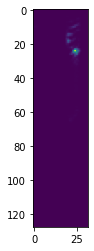

(128, 32, 3)


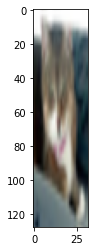

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
104/104 [==============================] - 96s 902ms/step - loss: 1.0001 - conv2d_35_loss: 137.5434 - conv2d_19_loss: 0.0373 - val_loss: 0.8422 - val_conv2d_35_loss: 116.6679 - val_conv2d_19_loss: 0.0255
Epoch 2/20
104/104 [==============================] - 93s 899ms/step - loss: 0.3934 - conv2d_35_loss: 51.9006 - conv2d_19_loss: 0.0301 - val_loss: 0.8719 - val_conv2d_35_loss: 121.2879 - val_conv2d_19_loss: 0.0229
Epoch 3/20
104/104 [==============================] - 93s 900ms/step - loss: 0.3102 - conv2d_35_loss: 40.3897 - conv2d_19_loss: 0.0274 - val_loss: 0.8424 - val_conv2d_35_loss: 116.8676 - val_conv2d_19_loss: 0.0243
Epoch 4/20
104/104 [==============================] - 94s 900ms/step - loss: 0.3021 - conv2d_35_loss: 39.2801 - conv2d_19_loss: 0.0271 - val_loss: 0.8890 - val_conv2d_35_loss: 123.9674 - val_conv2d_19_loss: 0.0213
Epoch 5/20
104/104 [==============================] - 93s 899ms/step - loss: 0.4538 - conv2d_35_loss: 60.9059 - conv2d_19_loss: 0.0275 - val_lo

In [ ]:
from keras.datasets import fashion_mnist,cifar10
(trainX, trainy), (testX, testy) = cifar10.load_data()

image_dataset_list = trainX
# all_audio_melpectrograms_list = np.load("/content/drive/MyDrive/ML1_Course_Project/all_mel_spectrograms.npy")


# input_1_secret,input_2_cover = get_img_batch(all_audio_melpectrograms_list,image_dataset_list, batch_size = len(all_audio_melpectrograms_list))
# print(type(input_1_secret[0]))
# print(type(input_2_cover[0]))

# train_input_1_secret, test_input_1_secret, train_input_2_cover, test_input_2_cover = train_test_split(input_1_secret, input_2_cover, test_size=0.2, shuffle = True,random_state=21)

# print("train_input_1_secret",train_input_1_secret.shape)
# print("train_input_1_secret",train_input_2_cover.shape)
# print("test_input_1_secret",test_input_1_secret.shape)
# print("test_input_2_cover",test_input_2_cover.shape)

# np.save("/content/drive/MyDrive/ML1_Course_Project/train_input_1_secret_32.npy",train_input_1_secret)
# np.save("/content/drive/MyDrive/ML1_Course_Project/train_input_2_cover_cifar.npy",train_input_2_cover)
# np.save("/content/drive/MyDrive/ML1_Course_Project/test_input_1_secret_32.npy",test_input_1_secret)
# np.save("/content/drive/MyDrive/ML1_Course_Project/test_input_2_cover_cifar.npy",test_input_2_cover)

train_input_1_secret = np.load("/content/drive/MyDrive/ML1_Course_Project/train_input_1_secret_32.npy")
train_input_2_cover = np.load("/content/drive/MyDrive/ML1_Course_Project/train_input_2_cover_cifar.npy")
test_input_1_secret = np.load("/content/drive/MyDrive/ML1_Course_Project/test_input_1_secret_32.npy")
test_input_2_cover = np.load("/content/drive/MyDrive/ML1_Course_Project/test_input_2_cover_cifar.npy")

print(train_input_1_secret[0].shape)
plt.imshow(train_input_1_secret[0].reshape(train_input_1_secret[0].shape[0],train_input_1_secret[0].shape[1]))
plt.show()
print(train_input_2_cover[0].shape)
plt.imshow(train_input_2_cover[0])#.reshape(train_input_2_cover[0].shape[0],train_input_2_cover[0].shape[1]))
plt.show()
print()

from tensorflow.keras import losses
num_epochs = 20
with tf.device('/device:GPU:0'):
  losses = {
	"conv2d_35": losses.mean_squared_error,
	"conv2d_19": losses.mean_squared_error,
  }
  lossWeights = {"conv2d_35": 0.007, "conv2d_19":1.0}

  # reveal_model.compile(optimizer='adam',loss = stegnography_custom_loss_function)
  # history = reveal_model.fit([input_1, input_2], [input_1, input_2],epochs = 10, verbose = 1)
  optim = tf.keras.optimizers.Adam(lr=0.0001)
  # optim = tf.keras.optimizers.SGD(lr=0.0001)
  # reveal_model.compile(optimizer=optim,loss=stegnography_custom_loss_function)
  reveal_model.compile(optimizer=optim,loss = losses,loss_weights=lossWeights)
  # reveal_model.compile(optimizer=optim,loss = ["mse","mse"],loss_weights=[0.7,100.0])#0.8/(1.5+0.8),1.5/(1.5+0.8)]) ##[audio weightage,image weightage]
  history = reveal_model.fit([train_input_1_secret, train_input_2_cover], [train_input_1_secret, train_input_2_cover],epochs = num_epochs, verbose = 1,batch_size=32,validation_split=0.2)
  reveal_model.save("/content/drive/MyDrive/ML1_Course_Project/audio_image_steganography_model_cifar.h5")


dict_keys(['loss', 'conv2d_35_loss', 'conv2d_19_loss', 'val_loss', 'val_conv2d_35_loss', 'val_conv2d_19_loss'])


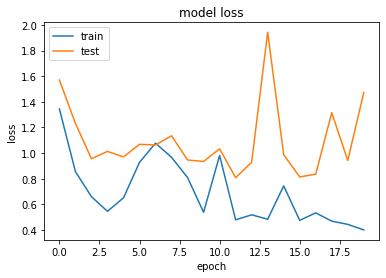

In [ ]:
3# print(history.history['val_loss'])
# print(history.history['train_loss'])
# train_loss_values = history.history['train_loss']
# val_loss_values = history.history['val_loss']
# epochs = np.arange(0,num_epochs)
# plt.plot(epochs,train_loss_values)
# plt.plot(epochs,val_loss_values)

print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



(1038, 128, 32, 1)
(1038, 128, 32, 3)
WAV file: mel Fs = 16000, x.shape = (15872,), x.dtype = float32


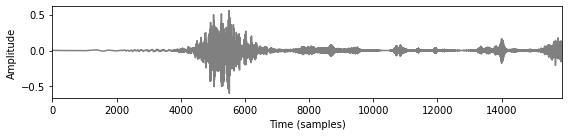

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(128, 32, 3)


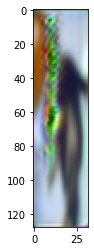

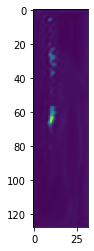

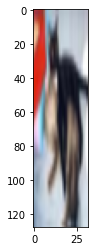

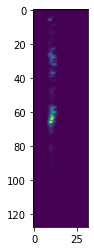

WAV file: mel Fs = 16000, x.shape = (15872,), x.dtype = float32


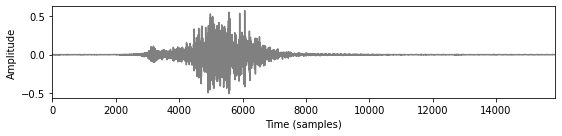

In [ ]:
revealed_audio, container_image = reveal_model.predict([[test_input_1_secret, test_input_2_cover]])
print(revealed_audio.shape)
print(container_image.shape)

### output audio ###
b = revealed_audio[0].reshape(revealed_audio[0].shape[0],revealed_audio[0].shape[1])
h = librosa.feature.inverse.mel_to_stft(b)
a = librosa.griffinlim(h)
print_plot_play(x=a, Fs=16000, text='WAV file: mel')

#### output spectrogram and image ####
container_image_0 = container_image[0]#.reshape(container_image[0].shape[0],container_image[0].shape[1])
plt.imshow(container_image_0)
print(container_image_0.shape)
plt.show()
plt.imshow(b)
plt.show()

#### input original spectrogram and image ####
original_audio = test_input_1_secret[0].reshape(test_input_1_secret[0].shape[0],test_input_1_secret[0].shape[1])
original_image = test_input_2_cover[0]#.reshape(test_input_2_cover[0].shape[0],test_input_2_cover[0].shape[1])

plt.imshow(original_image)
plt.show()
plt.imshow(original_audio)
plt.show()

### original input audio ####

h_original = librosa.feature.inverse.mel_to_stft(original_audio)
a_original = librosa.griffinlim(h_original)
print_plot_play(x=a_original, Fs=16000, text='WAV file: mel')






In [ ]:
print(np.amin(original_audio),np.amax(original_audio))
print(np.amin(revealed_audio),np.amax(revealed_audio))

print(np.amin(original_image),np.amax(original_image))
print(np.amin(container_image),np.amax(container_image))

5.183779e-21 70.47966
-0.87155485 325.55417
0.0 0.95672905
-0.61368674 0.3891306


In [ ]:
original_audio.shape

(128, 44)

(4150, 128, 44, 1)
(4150, 128, 44, 1)
WAV file: mel Fs = 22050, x.shape = (22016,), x.dtype = float32


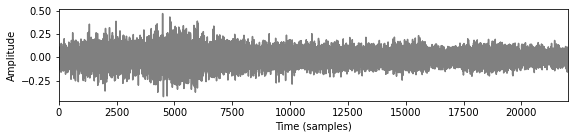

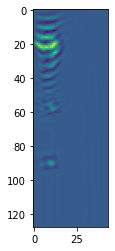

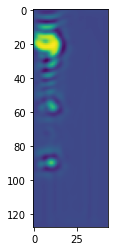

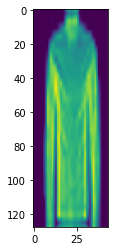

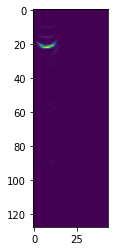

WAV file: mel Fs = 22050, x.shape = (22016,), x.dtype = float32


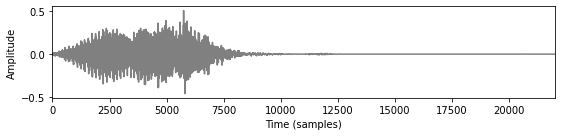

In [ ]:
revealed_audio, container_image = reveal_model.predict([[train_input_1_secret, train_input_2_cover]])
print(revealed_audio.shape)
print(container_image.shape)

### output audio ###
b = revealed_audio[0].reshape(revealed_audio[0].shape[0],revealed_audio[0].shape[1])
h = librosa.feature.inverse.mel_to_stft(b)
a = librosa.griffinlim(h)
print_plot_play(x=a, Fs=22050, text='WAV file: mel')

#### output spectrogram and image ####
container_image = container_image[0].reshape(container_image[0].shape[0],container_image[0].shape[1])
plt.imshow(container_image)
plt.show()
plt.imshow(b)
plt.show()

#### input original spectrogram and image ####
original_audio = train_input_1_secret[0].reshape(test_input_1_secret[0].shape[0],test_input_1_secret[0].shape[1])
original_image = train_input_2_cover[0].reshape(test_input_2_cover[0].shape[0],test_input_2_cover[0].shape[1])

plt.imshow(original_image)
plt.show()
plt.imshow(original_audio)
plt.show()

### original input audio ####

h_original = librosa.feature.inverse.mel_to_stft(original_audio)
a_original = librosa.griffinlim(h_original)
print_plot_play(x=a_original, Fs=22050, text='WAV file: mel')






WAV file: mel Fs = 22050, x.shape = (22016,), x.dtype = float32


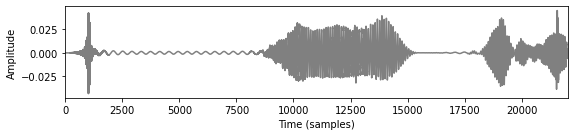

In [ ]:
b = revealed_audio[0].reshape(revealed_audio[0].shape[0],revealed_audio[0].shape[1])
h = librosa.feature.inverse.mel_to_stft(b)
a = librosa.griffinlim(h)
print_plot_play(x=a, Fs=22050, text='WAV file: mel')

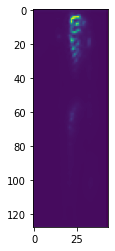

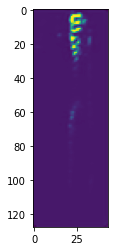

In [ ]:
ci = container_image[0].reshape(container_image[0].shape[0],container_image[0].shape[1])
plt.imshow(ci)
plt.show()
plt.imshow(b)
plt.show()

In [ ]:
original_image = test_input_1_secret[0].reshape(container_image[0].shape[0],container_image[0].shape[1])
original_audio = test_input_2_cover[0].reshape(container_image[0].shape[0],container_image[0].shape[1])

plt.imshow(original_image)
plt.show()
plt.imshow(original_audio)
plt.show()

IndexError: ignored

In [ ]:
import librosa
import os
import tensorflow.keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np
from tqdm import tqdm

DATA_PATH = "/content/drive/MyDrive/ML1_Course_Project/audio_data2/"


# Input: Folder Path
# Output: Tuple (Label, Indices of the labels, one-hot encoded labels)
def get_labels(path=DATA_PATH):
    labels = os.listdir(path)
    label_indices = np.arange(0, len(labels))
    return labels, label_indices, to_categorical(label_indices)


# convert file to wav2mfcc
# Mel-frequency cepstral coefficients
"""
# def wav2mfcc(file_path, n_mfcc=20, max_len=11):
#     wave, sr = librosa.load(file_path, mono=True, sr=None)
#     wave = np.asfortranarray(wave[::3])
#     mfcc = librosa.feature.mfcc(wave, sr=16000, n_mfcc=n_mfcc)

#     # If maximum length exceeds mfcc lengths then pad the remaining ones
#     if (max_len > mfcc.shape[1]):
#         pad_width = max_len - mfcc.shape[1]
#         mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')

#     # Else cutoff the remaining parts
#     else:
#         mfcc = mfcc[:, :max_len]
    
#     return mfcc
"""
def wav2mfcc(file_path, n_mfcc=20, max_len=40):
  wave, sr = librosa.load(file_path, mono=True, sr=None)
  # wave = np.asfortranarray(wave[::3])
  mfcc = librosa.feature.melspectrogram(wave, sr=22050)#, n_mfcc=n_mfcc)
  print(mfcc.shape[1])
  # If maximum length exceeds mfcc lengths then pad the remaining ones
  if (max_len >= mfcc.shape[1]):
      # print("d")
      pad_width = max_len - mfcc.shape[1]
      mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')

  # Else cutoff the remaining parts
  else:
      # print("abc")
      mfcc = mfcc[:, :max_len]
  
  return mfcc


def save_data_to_array(path=DATA_PATH, max_len=32, n_mfcc=20):
    labels, _, _ = get_labels(path)

    for label in labels:
        # Init mfcc vectors
        mfcc_vectors = []

        wavfiles = [path + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]
        for wavfile in tqdm(wavfiles, "Saving vectors of label - '{}'".format(label)):
            mfcc = wav2mfcc(wavfile, max_len=max_len, n_mfcc=n_mfcc)
            mfcc_vectors.append(mfcc)
            break ###
        np.save(label + '.npy', mfcc_vectors)
        break ###

def get_train_test(split_ratio=0.6, random_state=42):
    # Get available labels
    labels, indices, _ = get_labels(DATA_PATH)

    # Getting first arrays
    X = np.load(labels[0] + '.npy')
    y = np.zeros(X.shape[0])

    # Append all of the dataset into one single array, same goes for y
    print(labels)
    for i, label in enumerate(labels[0:]): ###labels
        x = np.load(label + '.npy')
        X = np.vstack((X, x))
        y = np.append(y, np.full(x.shape[0], fill_value= (i + 1)))
        break ###

    assert X.shape[0] == len(y)

    return train_test_split(X, y, test_size= (1 - split_ratio), random_state=random_state, shuffle=True)



def prepare_dataset(path=DATA_PATH):
    labels, _, _ = get_labels(path)
    data = {}
    for label in labels:
        data[label] = {}
        data[label]['path'] = [path  + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]

        vectors = []

        for wavfile in data[label]['path']:
            wave, sr = librosa.load(wavfile, mono=True)
            # Downsampling
            # wave = wave[::3]
            mfcc = librosa.feature.melspectrogram(wave, sr=22050)
            vectors.append(mfcc)
            break ### 
        data[label]['mfcc'] = vectors
        break ###

    return data


def load_dataset(path=DATA_PATH):
    data = prepare_dataset(path)

    dataset = []

    for key in data:
        for mfcc in data[key]['mfcc']:
            dataset.append((key, mfcc))

    return dataset[:100]


hello_data = prepare_dataset(DATA_PATH)

